In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pickle
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XES_functions import *

import warnings
warnings.filterwarnings('ignore')

## Load the run

In [2]:
pgroup='p21211'
runnumber = 133
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
print (jsonfile)
run_name = jsonfile.split('/')[-3]
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
if scan.parameters['scan_name'] != 'dummy':
    if scan.parameters['units'] == ['fs']:
        Timezero_mm = get_timezero_NBS(jsonfile)
        scanvar = scan.readbacks - mm2fs(Timezero_mm, 0)
    else: 
        scanvar = scan.readbacks
    print ('Scan contains {} step(s), scanvar goes from {:.2f} to {:.2f} {}'.format(len(scan), scanvar[0], scanvar[-1], scan.parameters['units'][0]))
else:
    print ('No motors moved')

run: 0133
/sf/alvra/data/p21211/raw/run0133-XES_timescan-short_CpStRh/meta/scan.json
Scan contains 65 step(s), scanvar goes from -496.34 to 24997.96 fs


In [3]:
threshold_low = 2
threshold_high = 10

Timezero_mm = 100.02694

channels_list = []

reducedir='../Claudio/Reduced_XES_timescans/'

rotflag = True
angle_file= '../Claudio/Reduced_RIXS/angle_mean_rot.pkl'

saveflag = True
#####################################################

import sfdata.sfdatafile
sfdata.sfdatafile.ju = None
scan = SFScanInfo(jsonfile)

angle_mean = {}
angle_mean = defaultdict(int, angle_mean)
if rotflag:
    with open(angle_file, 'rb') as f:
        angle_mean = pickle.load(f)

try:
    Timezero_mm = get_timezero_NBS(jsonfile)
    flag = True
except:        
    Timezero_mm = Timezero_mm
    flag = False
    
spectra_on, spectra_off,_,_,_,_, ROIs, Delay_fs, Delay_mm, meta = XES_delayscan_ROIs(scan, channels_list, threshold_low, threshold_high, angle_rot=angle_mean)

print ('------------------------------')
if flag:
    print ('Timezero found in file = {} mm'.format(Timezero_mm))
else:
    print ('Timezero = {} mm'.format(Timezero_mm))

if scan.parameters['units'] == ['nS']:
    Delay_fs = scan.values
#    Delay_fs = Delay_fs - 0.17
else:
    Delay_fs = scan.values
    Delay_fs = Delay_fs - mm2fs(Timezero_mm, 0)
    
if saveflag:
    os.makedirs(reducedir+run_name, exist_ok=True)
    save_data_XES_timescans_ROIs(reducedir, run_name, spectra_on, spectra_off, ROIs, Delay_mm, Delay_fs, meta)
print ('------------------------------')
for ROI in ROIs:
    if "bkg" in ROI:
        continue
    print ('Reduced {} data rotated by {}'.format(ROI, angle_mean[ROI]))

Took 30.65 seconds for the previous step
Processing: run0133-XES_timescan-short_CpStRh
Step 65 of 65: Processing acq0065

--------------------------------------------------------------------------------

JF02T09V03:ROI_LbDW1    1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_LbDW2    1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_LbUP1    1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
JF02T09V03:ROI_LbUP2    1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAR-CVME-TIFALL4:EvtSet 1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1001 / 1001 -> 0% loss
complete channels: 5 / 5 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 498 pump and 498 unpump shots
------------------------------
Timezero found in file = 142.344720000045 mm
------------------------------
Reduced JF02T09V03:ROI_LbDW1 data rotated by 4.625000000004632
Reduced JF02T09V03:ROI_LbDW2 data rot

-0.19736842105263158 4223.092105263158
-0.20366068585492392 3611.273800856137
-0.19993766752315395 4236.2225430137005
-0.21693727044408226 3636.160896581792


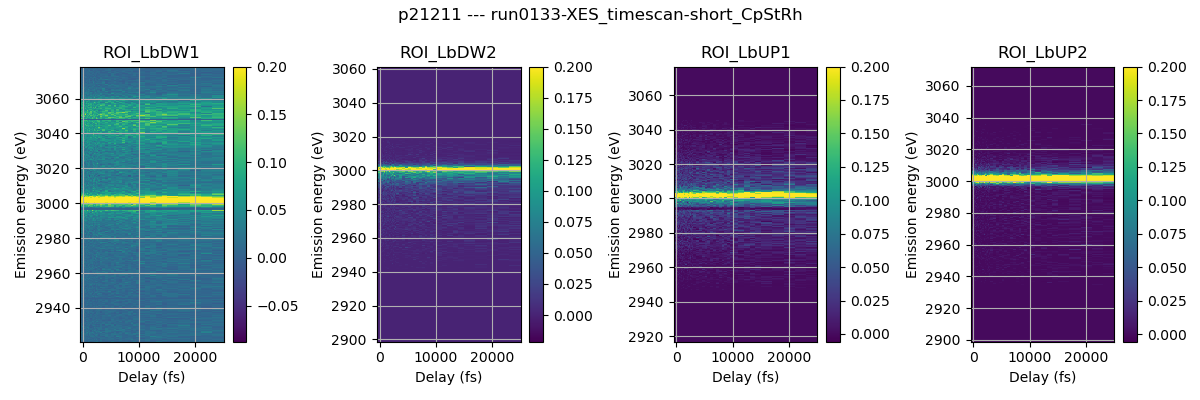

In [4]:
energy_calib = True
Loaddir = '../Claudio/Reduced_RIXS/'

bin_ = 1

vmin = None
vmax = 0.2

################################################
try:
    with open(Loaddir+'Energy_calib/calibration.pkl', 'rb') as f:
        calibration = pickle.load(f)
except:
    print ('No energy calibration file found!')

fig, axs = plt.subplots(nrows=1, ncols=len(ROIs[0::1]), figsize=(12,4))
plt.suptitle(titlestring)
for i, (ROI, ax) in enumerate(zip(ROIs[0::1], axs.flatten())):
    matrix_off = []
    for index_step in range(len(spectra_off)):
        matrix_off.append(spectra_off[index_step][ROI])#.split(':')[-1]])
        
    yaxis = np.arange(np.array(meta[ROI+'-roi']).flatten()[-2], np.array(meta[ROI+'-roi']).flatten()[-1], 1)
    y_axis_rebin, matrix_off_rebin = plot_tool_static_2D(matrix_off, 0, yaxis, bin_)
    
    ylabel = 'JF pixel'
    if energy_calib:
        m,b = calibration[ROI]
        y_axis_rebin = m*y_axis_rebin + b
        ylabel = 'Emission energy (eV)'
        print (m,b)
        
    plt.sca(ax)
    plt.title(ROI.split(':')[-1])
    plt.pcolormesh(Delay_fs, y_axis_rebin, np.transpose(np.asarray(matrix_off_rebin)), vmin = vmin, vmax = vmax)
    #plt.plot(Delay_fs, np.transpose(np.asarray(matrix_off_rebin)).sum(axis=0))
    plt.colorbar()
    plt.ylabel(ylabel)
    #plt.ylim(3120, 3180)
    plt.grid()
    plt.xlabel('Delay ({})'.format(scan.parameters['units'][0]))
plt.tight_layout()

-0.19736842105263158 4223.092105263158
-0.20366068585492392 3611.273800856137
-0.19993766752315395 4236.2225430137005
-0.21693727044408226 3636.160896581792


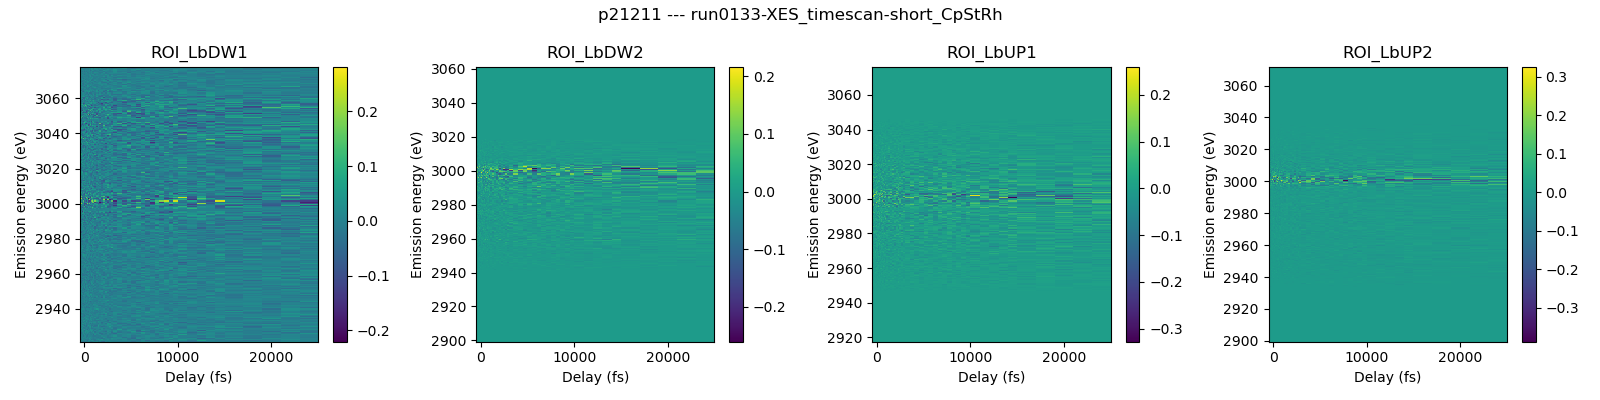

In [5]:
energy_calib = True
Loaddir = '../Claudio/Reduced_RIXS/'

bin_ = 3

vmin = None
vmax = None

################################################

fig, axs = plt.subplots(nrows=1, ncols=len(ROIs[0::1]), figsize=(16,4))
plt.suptitle(titlestring)
for i, (ROI, ax) in enumerate(zip(ROIs[0::1], axs.flatten())):
    matrix_on = []
    matrix_off = []
    for index_step in range(len(spectra_on)):
        matrix_on.append(spectra_on[index_step][ROI])#.split(':')[-1]])
        matrix_off.append(spectra_off[index_step][ROI])#.split(':')[-1]])
        
    yaxis = np.arange(np.array(meta[ROI+'-roi']).flatten()[-2], np.array(meta[ROI+'-roi']).flatten()[-1], 1)
    y_axis_rebin, matrix_on_rebin, matrix_off_rebin = plot_tool_2D(matrix_on, matrix_off, 0, yaxis, bin_)
    
    ylabel = 'JF pixel'
    if energy_calib:
        m,b = calibration[ROI]
        y_axis_rebin = m*y_axis_rebin + b
        ylabel = 'Emission energy (eV)'
        print (m,b)
    
    plt.sca(ax)
    plt.title(ROI.split(':')[-1])
    plt.pcolormesh(Delay_fs, y_axis_rebin, np.transpose(np.asarray(matrix_on_rebin) - np.asarray(matrix_off_rebin)), vmin = vmin, vmax = vmax)
    plt.colorbar()
    plt.ylabel(ylabel)
    #plt.ylim(3120, 3180)
    plt.xlabel('Delay ({})'.format(scan.parameters['units'][0]))
plt.tight_layout()

-0.19993766752315395 4236.2225430137005


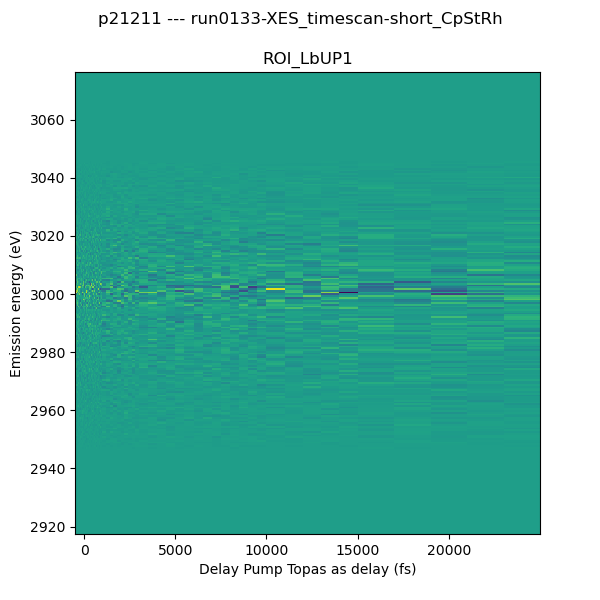

In [6]:
ROI = 'JF02T09V03:ROI_LbUP1'

energy_calib = True
Loaddir = '../Claudio/Reduced_RIXS/'

bin_ = 3

vmin = None
vmax = None

##########################################################

plt.figure(figsize=(6,6))
plt.suptitle(titlestring)
matrix_on = []
matrix_off = []
for index_step in range(len(spectra_on)):
    matrix_on.append(spectra_on[index_step][ROI])#.split(':')[-1]])
    matrix_off.append(spectra_off[index_step][ROI])#.split(':')[-1]])

yaxis = np.arange(np.array(meta[ROI+'-roi']).flatten()[-2], np.array(meta[ROI+'-roi']).flatten()[-1], 1)
y_axis_rebin, matrix_on_rebin, matrix_off_rebin = plot_tool_2D(matrix_on, matrix_off, 0, yaxis, bin_)

ylabel = 'JF pixel'
if energy_calib:
    m,b = calibration[ROI]
    y_axis_rebin = m*y_axis_rebin + b
    ylabel = 'Emission energy (eV)'
    print (m,b)

plt.title(ROI.split(':')[-1])
#plt.plot(Delay_fs, (np.transpose(np.asarray(matrix_on_rebin) - np.asarray(matrix_off_rebin))[31]))

plt.pcolormesh(Delay_fs, y_axis_rebin, np.transpose(np.asarray(matrix_on_rebin) - np.asarray(matrix_off_rebin)), vmin = vmin, vmax = vmax)
#plt.pcolormesh(Delay_fs, y_axis_rebin, np.transpose(np.asarray(matrix_on_rebin)), vmin = vmin, vmax = vmax)
#plt.colorbar()
plt.ylabel(ylabel)
#plt.ylim(2950, 3050)
#plt.axhline(y = 5098, color = 'r', linestyle = '-')
#plt.axvline(x = 2.55, color = 'r', linestyle = '-')

plt.xlabel('{} ({})'.format(scan.parameters['name'][0], scan.parameters['units'][0]))
plt.show()

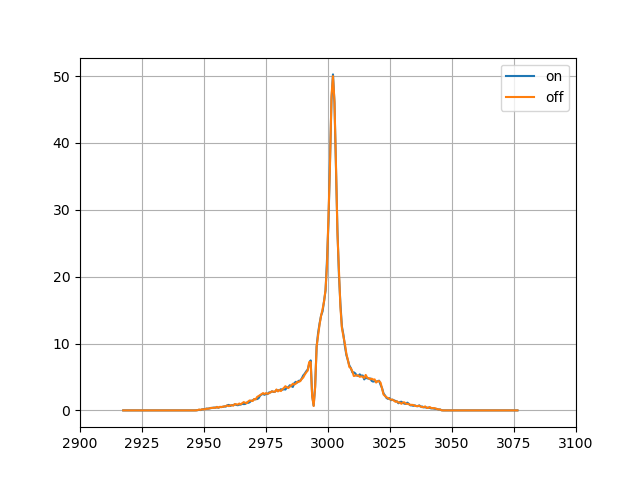

In [8]:
plt.figure()
mat_off  = np.transpose(np.asarray(matrix_off_rebin))
mat_on   = np.transpose(np.asarray(matrix_on_rebin))
proj_off = np.sum(mat_off, axis=1)
proj_on = np.sum(mat_on, axis=1)

plt.plot(y_axis_rebin, proj_on, label = 'on')
plt.plot(y_axis_rebin, proj_off, label = 'off')

plt.grid()
plt.legend(loc='best')
plt.xlim(2900, 3100)

plt.show()

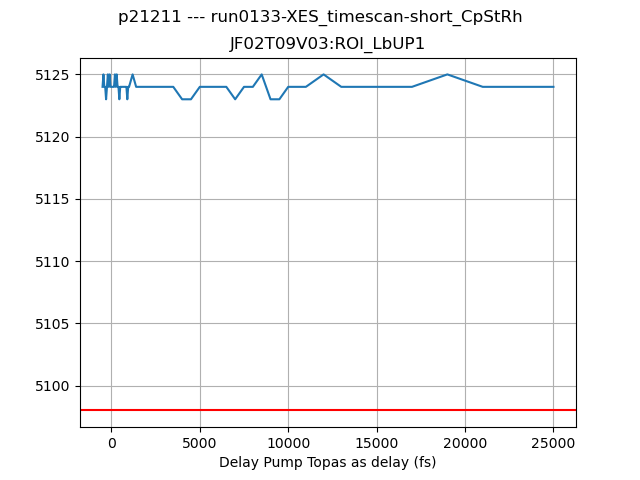

In [9]:
plt.figure()
plt.suptitle(titlestring)
plt.title(ROI)
plt.plot(Delay_fs, 5000+np.argmax(np.transpose(np.asarray(matrix_on_rebin) + np.asarray(matrix_off_rebin)), axis=0))
plt.axhline(y = 5098, color = 'r', linestyle = '-')
plt.xlabel('{} ({})'.format(scan.parameters['name'][0], scan.parameters['units'][0]))
plt.grid()
plt.show()

In [9]:
def rebin2D(arr, axis, bin_):
    arr = np.array(arr)
    arr_new=[]
    if axis == 1:
        arr=arr.T
    for index in range(len(arr)):
        cut=arr[index]
        new=bin_sum(cut,bin_)
        arr_new.append(new)
    arr_new=np.array(arr_new)
    if axis == 1:
        arr_new=arr_new.T
    return arr_new

In [10]:
def plot_tool_2D(matrix_ON, matrix_OFF, axis, x_axis, bin_):
    
    matrix_on_rebin  = rebin2D(matrix_ON, axis, bin_)
    matrix_off_rebin = rebin2D(matrix_OFF, axis, bin_)
    x_axis_rebin = bin_mean(x_axis, bin_)
    
    return x_axis_rebin, matrix_on_rebin, matrix_off_rebin#, low_err, high_err

In [11]:
def plot_tool_static_2D(matrix, axis, x_axis, bin_):
    
    matrix_rebin  = rebin2D(matrix, axis, bin_)
    x_axis_rebin = bin_mean(x_axis, bin_)
    
    return x_axis_rebin, matrix_rebin